<h1 style="text-align:center;">Computational Intelligence</h1>
<h2 style="text-align:center;">Time Series Forecasting with Recurrent Neural Network (CNN)</h2>
<h4 style="text-align:center;">by H. Naderan</h4>
<h5 style="text-align:center;">
Mechanical Engineering Department<br>
Amirkabir University of Technology
</h5>

***

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10)) # wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5) # + noise

    return series[..., np.newaxis].astype(np.float32)

In [4]:
nsteps = 50
series = generate_time_series(10000, nsteps + 1)
Xtrain, Ytrain = series[:7000, :nsteps], series[:7000, -1]
Xvalid, Yvalid = series[7000:9000, :nsteps], series[7000:9000, -1]
Xtest, Ytest = series[9000:, :nsteps], series[9000:, -1]

### Loading libraries

In [5]:
import os
os.environ["KERAS_BACKEND"] = "torch"
import keras_core as keras

Using PyTorch backend.


/home/hamid/codes/python-CI/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


### Baseline performance

#### Naive approach (last value prediction)

In [6]:
Ypred = Xvalid[:, -1]
np.mean(keras.losses.mean_squared_error(Yvalid, Ypred).numpy())

np.float32(0.020073323)

#### Simple MLP (Linear model)

In [7]:
epochs = 10

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
)

trainState = model.fit(
    Xtrain,
    Ytrain,
    epochs=epochs,
    validation_data=(Xvalid, Yvalid)
)

Epoch 1/10


 63/219 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3787       

/home/hamid/codes/python-CI/.venv/lib64/python3.12/site-packages/keras_core/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2547 - val_loss: 0.0490
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0382 - val_loss: 0.0159
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0130 - val_loss: 0.0081
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0071 - val_loss: 0.0060
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0055 - val_loss: 0.0054
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0051 - val_loss: 0.0051
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0048 - val_loss: 0.0049
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 9/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0044 - val_loss: 0.0045
Epoch 10/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0045 - val_loss: 0.0045


In [8]:
Ypred = model.predict(Xvalid)
np.mean(keras.losses.mean_squared_error(Yvalid, Ypred).numpy())

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step      


np.float32(0.004463496)

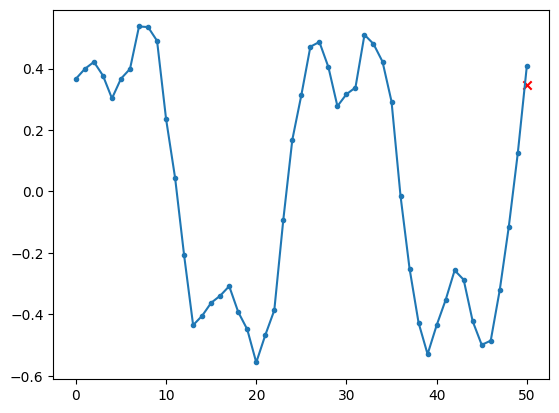

In [ ]:
plt.plot(np.hstack((Xvalid[0, :, 0], Yvalid[0])), marker = '.')
plt.scatter([nsteps], Ypred[0], marker = 'x', c = "red")

### Single RNN

In [17]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])
model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
)
trainState = model.fit(
    Xtrain,
    Ytrain,
    #batch_size=batch_size,
    epochs=epochs,
    validation_data=(Xvalid, Yvalid)
)

Epoch 1/10


  5/219 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.3531

/home/hamid/codes/python-CI/.venv/lib64/python3.12/site-packages/keras_core/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.3819 - val_loss: 0.3440
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.3326 - val_loss: 0.2979
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.2947 - val_loss: 0.2594
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.2512 - val_loss: 0.2205
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.2157 - val_loss: 0.1884
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 0.1786 - val_loss: 0.1622
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 0.1542 - val_loss: 0.1408
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.1373 - val_loss: 0.1243
Epoch 9/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.1191 - val_loss: 0.1094
Epoch 10/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.1020 - val_loss: 0.0888


In [11]:
Ypred = model.predict(Xvalid)
np.mean(keras.losses.mean_squared_error(Yvalid, Ypred).numpy())

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step


np.float32(0.21708149)

### Multilayer RNN

In [12]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
)

trainState = model.fit(
    Xtrain,
    Ytrain,
    #batch_size=batch_size,
    epochs=epochs,
    validation_data=(Xvalid, Yvalid)
)

Epoch 1/10
  2/219 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - loss: 0.2416

/home/hamid/codes/python-CI/.venv/lib64/python3.12/site-packages/keras_core/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - loss: 0.0414 - val_loss: 0.0049
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 22s 99ms/step - loss: 0.0044 - val_loss: 0.0038
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 22s 100ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 19s 88ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 22s 99ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 9/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 10/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 18s 81ms/step - loss: 0.0029 - val_loss: 0.0028


In [13]:
Ypred = model.predict(Xvalid)
np.mean(keras.losses.mean_squared_error(Yvalid, Ypred).numpy())

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step


np.float32(0.0027930709)

### Predicting multiple values

In [18]:
series = generate_time_series(10000, nsteps + 10)
X_train, Y_train = series[:7000, :nsteps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :nsteps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :nsteps], series[9000:, -10:, 0]

In [15]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
)

trainState = model.fit(
    Xtrain,
    Ytrain,
    #batch_size=batch_size,
    epochs=epochs,
    validation_data=(Xvalid, Yvalid)
)

Epoch 1/10
  1/219 ━━━━━━━━━━━━━━━━━━━━ 24s 112ms/step - loss: 0.4032

/home/hamid/codes/python-CI/.venv/lib64/python3.12/site-packages/keras_core/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 22s 102ms/step - loss: 0.0931 - val_loss: 0.0071
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 25s 114ms/step - loss: 0.0059 - val_loss: 0.0046
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 22s 100ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 23s 103ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 22s 101ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 22s 99ms/step - loss: 0.0035 - val_loss: 0.0037
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 22s 99ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 9/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 10/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 19s 87ms/step - loss: 0.0033 - val_loss: 0.0035


In [16]:
Ypred = model.predict(Xvalid)
np.mean(keras.losses.mean_squared_error(Yvalid, Ypred).numpy())

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step


np.float32(0.0034810754)

In [ ]:
plt.plot(np.hstack((Xvalid[0, :, 0], Yvalid[0, :])), marker = '.')
plt.scatter([nsteps:(nsteps + 10)], Ypred[0, :], marker = 'x', c = "red")

### Sequence to sequence model

In [20]:
Y = np.empty((10000, nsteps, 10)) # each target is a sequence of 10D vectors
for step_ahead in range(1, 10 + 1):
    Y[:, :, step_ahead - 1] = series[:, step_ahead:step_ahead + nsteps, 0]
Ytrain = Y[:7000]
Yvalid = Y[7000:9000]
Ytest = Y[9000:]

In [ ]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics = [last_time_step_mse]
)

trainState = model.fit(
    Xtrain,
    Ytrain,
    #batch_size=batch_size,
    epochs=epochs,
    validation_data=(Xvalid, Yvalid)
)

In [ ]:
Ypred = model.predict(Xvalid)
keras.losses.mean_squared_error(Yvalid, Ypred)

### LSTM Network

In [ ]:
model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics = [last_time_step_mse]
)

trainState = model.fit(
    Xtrain,
    Ytrain,
    #batch_size=batch_size,
    epochs=epochs,
    validation_data=(Xvalid, Yvalid)
)

In [ ]:
Ypred = model.predict(Xvalid)
keras.losses.mean_squared_error(Yvalid, Ypred)

### Combining convolutional layer with RNN

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2,padding="valid", input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics = [last_time_step_mse]
)

history = model.fit(
    Xtrain, 
    Ytrain[:, 3::2], 
    epochs=epochs,
    validation_data=(Xvalid, Yvalid[:, 3::2])
)